In [1]:
import pandas as pd
import numpy as np

# 1. Load your original data
df = pd.read_csv("features.csv", parse_dates=["public_date"])
df = df.rename(columns={'public_date': 'date'}) # rename public_date to date

# remove columns that are called "gvkey", "cusip", "TICKER", "permno", "adate", "qdate"
df = df.drop(columns=["gvkey", "cusip", "permno", "adate", "qdate"])

# 2. For each ticker, read its CSV, rename columns, tag with ticker, and keep only the needed cols
price_frames = []
for ticker in ["AAPL", "MSFT", "NVDA", "TSLA", "IBM"]:
    tmp = pd.read_csv(f"{ticker}.csv", parse_dates=["Date"])
    tmp = tmp.rename(columns={
        "Date": "date",
        "Close/Last": "Close/Last"
    })
    tmp["TICKER"] = ticker
    price_frames.append(tmp[["date", "TICKER", "Close/Last"]])

# 3. Stack them all into one DataFrame
price_df = pd.concat(price_frames, ignore_index=True)

# 4. Merge onto your original df by both date and ticker
df_merged = pd.merge(
    df,
    price_df,
    on=["date", "TICKER"],
    how="inner"   # or "inner" if you only want rows where a price exists
)
# remove all columns that have any NA values
df_merged = df_merged.dropna(axis=1)

# remove dollar signs and commas from Close/Last
df_merged["Close/Last"] = df_merged["Close/Last"].str.replace("$", "", regex=False)
# make the values in Close/Last numeric
df_merged["Close/Last"] = pd.to_numeric(df_merged["Close/Last"], errors="coerce")

# create a new column called return that is the percentage change of Close/Last
df_merged["return"] = df_merged.groupby("TICKER")["Close/Last"].pct_change()

# create a new column called y, if the return for the next month is greater than 0, then y = 1, else y = 0
df_merged["y"] = df_merged.groupby("TICKER")["return"].shift(-1)
# if y > 0, then y = 1, else y = 0
df_merged["y"] = df_merged["y"].apply(lambda x: 1 if x > 0 else 0)

# 2. Extract the year into its own column
df_merged["year"] = df_merged["date"].dt.year

# 3. Figure out which years are “first five vs. “last one”
years = sorted(df_merged["year"].unique())
train_years = years[:5]    # first five unique years
test_year = years[-1]       # last unique year

# remove rows with missing values
df_merged = df_merged.dropna()
# 4. Split
train_df = df_merged[df_merged["year"].isin(train_years)].copy()
test_df  = df_merged[df_merged["year"] == test_year].copy()

# 5. drop the helper column
train_df.drop(columns="year", inplace=True)
test_df .drop(columns="year", inplace=True)

# 6. Quick sanity check
print(f"Training on years: {train_years}")
print(f"Testing on year:   {test_year}")
print(f"Train set size:    {train_df.shape}")
print(f"Test set size:     {test_df.shape}")

Training on years: [2015, 2016, 2017, 2018, 2019]
Testing on year:   2024
Train set size:    (195, 63)
Test set size:     (40, 63)


In [2]:

# remove dollar signs and commas from Close/Last
price_df["Close/Last"] = price_df["Close/Last"].str.replace("$", "", regex=False)

# make the values in Close/Last numeric
price_df["Close/Last"] = pd.to_numeric(price_df["Close/Last"], errors="coerce")


# make sure time stamps are real datetimes & sorted
price_df['date'] = pd.to_datetime(price_df['date'])
price_df         = price_df.sort_values(['TICKER', 'date'])

price_df["return"] = price_df.groupby("TICKER")["Close/Last"].pct_change()


assets  = ['IBM','NVDA','AAPL','TSLA','MSFT']
W       = 20                     # trailing‑window length
freq    = 'ME'                    # snapshot granularity

# 1) daily returns in a wide table  --------------------------
daily_ret = (price_df
             .assign(date = pd.to_datetime(price_df['date']))
             .pivot(index='date', columns='TICKER', values='return')
             .sort_index())                          # rows = dates, cols = tickers

# 2) month‑end trading days that have *all* five tickers -----
snap_dates = (daily_ret
              .dropna()                              # rows with no NaN in any asset
              .resample(freq)
              .last()                                # last trading day in each month
              .index)

features = [c for c in train_df.columns if c!="date" and c!="TICKER" and c!="return" and c!="y" and c!="Close/Last"] # 58
# randomly select 4 features
np.random.seed(42)
features = np.random.choice(features, 4, replace=False).tolist()


snapshots = []
for d, g in train_df.groupby('date'):
    window = daily_ret.loc[:d].tail(W)               # last W rows up to d
    if window.shape[0] < W:              # incomplete window → skip snapshot
        continue
    # ------------- X_feat --------------
    X_feat = g.set_index('TICKER')[features].values        
    R_hist = window[assets].T.values                 
    y = g.set_index('TICKER')['y'].values               
    snapshots.append({'X_feat': X_feat.astype(np.float32),
                    'returns_hist': R_hist.astype(np.float32),
                    'y': y})

In [3]:
import numpy as np
from typing import Tuple

def fit_linear_factor_model(X: np.ndarray,
                            Y: np.ndarray
                           ) -> Tuple[np.ndarray, np.ndarray]:
    """
    OLS estimate of θ₁  (Eq. 6.2)  and residual variance matrix 𝐅.
    
    Parameters
    ----------
    X : (n, d_x)   factor matrix
    Y : (n, d_y)   asset–return matrix
    
    Returns
    -------
    theta_hat : (d_x, d_y)  estimated regression coefficients
    F_hat     : (d_y, d_y)  diagonal matrix of residual variances
    """
    # --- 1.  θ̂₁ = (XᵀX)⁻¹ XᵀY  -----------------------------
    theta_hat, *_ = np.linalg.lstsq(X, Y, rcond=None)  # (d_x, d_y)

    # --- 2.  residuals  ε̂ = Y – X θ̂₁ ----------------------
    resid = Y - X @ theta_hat                            # (n, d_y)

    # --- 3.  𝐅̂ : diagonal residual variance matrix -------
    var_resid = resid.var(axis=0, ddof=1)                # (d_y,)
    F_hat = np.diag(var_resid)                           # (d_y, d_y)

    return theta_hat, F_hat

In [4]:
theta_hat, F_hat = fit_linear_factor_model(
    X=snapshots[0]['X_feat'],
    Y=snapshots[0]['returns_hist']
)

In [5]:
import mgarch
dist = 't'
vol = mgarch.mgarch(dist)
vol.fit(snapshots[0]['X_feat'])
ndays = 1 # volatility of nth day
W_t = vol.predict(ndays)['cov']

c:\Users\ksg\SVM_QP\.conda\lib\site-packages\mgarch\mgarch.py:91: RuntimeWarning: invalid value encountered in sqrt
  qts = np.linalg.inv(np.sqrt(np.diag(np.diag(Q_t[i]))))
c:\Users\ksg\SVM_QP\.conda\lib\site-packages\numpy\linalg\linalg.py:2180: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
c:\Users\ksg\SVM_QP\.conda\lib\site-packages\mgarch\mgarch.py:99: RuntimeWarning: invalid value encountered in log
  -(self.N/2.)*np.log(np.pi*(dof - 2)) - np.log(np.linalg.det(H_t[i])) \


In [6]:
W_t.shape

(4, 4)

In [285]:
def predict_conditional_distribution(x_t: np.ndarray,
                                     W_t: np.ndarray,
                                     theta_hat: np.ndarray,
                                     F_hat: np.ndarray
                                    ) -> Tuple[np.ndarray, np.ndarray]:
    """
    Implements Eq. (6.3):   ŷ⁽ᵗ⁾  and  V̂⁽ᵗ⁾  for a single date t.
    
    Parameters
    ----------
    x_t       : (d_x,)        factor-realisation today
    W_t       : (d_x, d_x)    factor covariance today
    theta_hat : (d_x, d_y)    learned coefficients
    F_hat     : (d_y, d_y)    residual variance matrix
    
    Returns
    -------
    y_hat_t : (d_y,)        conditional mean return
    V_hat_t : (d_y, d_y)    conditional covariance
    """
    y_hat_t = x_t.T @ theta_hat                     # ŷ⁽ᵗ⁾
    V_hat_t = theta_hat.T @ W_t @ theta_hat + F_hat  # V̂⁽ᵗ⁾
    return y_hat_t, V_hat_t

In [288]:
X_t = snapshots[0]['X_feat']
X_t.T.shape, W_t.shape, theta_hat.shape, F_hat.shape

((4, 5), (4, 4), (4, 20), (20, 20))

In [287]:
X_t = snapshots[0]['X_feat']

y_hat_t, V_hat_t = predict_conditional_distribution(X_t, W_t, theta_hat, F_hat)

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 4 is different from 5)

In [ ]:
y_hat_t

array([[-5.41948341e-03, -7.34290481e-03, -1.18974522e-02,
         3.14776599e-03,  1.85571350e-02,  1.26277665e-02,
        -2.69501656e-03, -4.63508070e-03,  1.87789220e-02,
         6.50017709e-03, -3.14578414e-03, -5.07442951e-02,
        -1.45059377e-02,  1.12323770e-02, -1.39229083e-02,
        -6.77078962e-03,  1.48926973e-02,  9.46952682e-03,
         1.55063346e-03,  5.33152185e-03],
       [-5.16561139e-03,  5.18545508e-04, -5.66741079e-03,
        -9.68203694e-03,  1.82976276e-02,  1.06341066e-02,
        -3.38557176e-03,  1.92765519e-03,  1.33921467e-02,
        -9.21592116e-04, -2.88423523e-03, -1.22505128e-02,
        -2.42890120e-02,  6.91482658e-03, -7.98366591e-03,
        -1.41948462e-04,  2.92936713e-03,  5.55593381e-03,
        -2.47639045e-03, -1.09646097e-03],
       [-6.30942732e-03, -1.03076994e-02, -2.54749730e-02,
        -2.13408545e-02,  2.64170989e-02,  1.76216643e-02,
         1.21936947e-03,  5.99820167e-03,  1.69276930e-02,
         6.60172850e-03,  1.2

In [264]:
snapshots[0]['y'].shape

(5,)

In [85]:
median_aapl = daily_ret['AAPL'].median()
median_msft = daily_ret['MSFT'].median()
median_nvda = daily_ret['NVDA'].median()
median_tsla = daily_ret['TSLA'].median()
median_ibm  = daily_ret['IBM'].median()
median_aapl, median_msft, median_nvda, median_tsla, median_ibm

(0.0008894155968700579,
 0.0009078822671798603,
 0.0026231468403467018,
 0.0012619902242324565,
 0.0006635584469198985)

In [86]:
import torch
from torch.utils.data import Dataset, DataLoader

class SVM_MVO_Set(Dataset):
    def __init__(self, snaps, return_goal=0.0006):
        self.snaps = snaps
        self.rg    = return_goal
    def __len__(self):  return len(self.snaps)
    def __getitem__(self, idx):
        s = self.snaps[idx]
        return ( torch.tensor(s['X_feat'],dtype=torch.float32),
                 torch.tensor(s['y'], dtype=torch.float32),
                 torch.tensor(s['returns_hist'], dtype=torch.float32),
                 torch.tensor(self.rg, dtype=torch.float32) )

loader = DataLoader(SVM_MVO_Set(snapshots), batch_size=5, shuffle=True)

In [87]:
import torch
import torch.nn as nn
from qpth.qp import QPFunction

class EndToEndSVM_MVO_Sigmoid(nn.Module):
    def __init__(self,
                 in_features: int,
                 C_svm: float,
                 eps: float,
                 tau: float):
        """
        in_features : number of raw features per asset
        C_svm       : SVM dual box‐constraint
        eps         : jitter to ensure all Q‐matrices are SPD
        tau         : sigmoid temperature for soft gating
        """
        super().__init__()
        self.embed = nn.Linear(in_features, in_features, bias=False)
        self.C   = C_svm
        self.eps = eps
        self.tau = tau

    def forward(self,
                X_feat: torch.Tensor,       # (n_assets, n_features)
                y: torch.Tensor,            # (n_assets,) in {+1, -1}
                returns_hist: torch.Tensor, # (n_assets, T)
                return_goal: float
               ) -> torch.Tensor:           # → (n_assets,) portfolio weights
        n, d = X_feat.shape
        # — ensure returns_hist is (n, T):
        returns_hist = returns_hist.squeeze()
        if returns_hist.dim() != 2:
            raise ValueError(f"returns_hist must be 2-D, got {returns_hist.shape}")
        if returns_hist.size(0) != n and returns_hist.size(1) == n:
            returns_hist = returns_hist.T
        if returns_hist.size(0) != n:
            raise ValueError(f"After reshape, returns_hist must match n_assets={n}, got {returns_hist.shape}")
        T = returns_hist.size(1)

        # 1) feature embedding
        Xp = self.embed(X_feat)   # (n, d)

        # 2) SVM dual QP
        K      = Xp @ Xp.t()                             # (n, n)
        yy     = y.view(-1,1) * y.view(1,-1)             # (n, n)
        Q_svm  = yy * K + self.eps * torch.eye(n, device=Xp.device, dtype=Xp.dtype)
        p_svm  = -torch.ones(n, device=Xp.device, dtype=Xp.dtype)

        G_svm  = torch.cat([
            -torch.eye(n, device=Xp.device, dtype=Xp.dtype),
             torch.eye(n, device=Xp.device, dtype=Xp.dtype)
        ], dim=0)                                        # (2n, n)
        h_svm  = torch.cat([
            torch.zeros(n, device=Xp.device, dtype=Xp.dtype),
            self.C * torch.ones(n, device=Xp.device, dtype=Xp.dtype)
        ], dim=0)                                        # (2n,)

        A_svm  = y.view(1,-1)#.to(Xp)                     # (1, n)
        b_svm  = torch.zeros(1, device=Xp.device, dtype=Xp.dtype)

        # ------------------  handle single‑class case ------------------
        if (y == y[0]).all():                         # all +1 *or* all -1
            A_svm, b_svm = None, None                # no equality constraint
        else:
            A_svm = y.view(1,-1)
            b_svm = torch.zeros(1, device=Xp.device)
        # ---------------------------------------------------------------
        
        α      = QPFunction(verbose=False)(
                    Q_svm, p_svm, G_svm, h_svm, A_svm, b_svm
                 )                                  # (n,)
        α      = torch.clamp(α, 0.0, self.C)

        # 3) build hyperplane and score
        # after solving for α
        # construct w_svm properly:
        # make sure alphas is a 1-D tensor of length 50
        α = α.view(-1)                # now shape [50]

        # ensure y is float or double to match alphas dtype
        y = y.to(α.dtype)                  # shape [50]

        # elementwise product alpha_i * y_i
        alpha_y = α * y                    # shape [50]
        w_svm = Xp.t().mv(alpha_y)                   # or torch.matmul(X.t(), alpha_y)

        scores = Xp @ w_svm                 # (n_assets,)


        # 4) differentiable sigmoid gate
        mask   = torch.sigmoid(scores / self.tau)        # (n,) in (0,1)

        # 5) MVO QP *over all assets* with w_i ≤ mask_i
        #    compute moments for every asset
        mu     = returns_hist.mean(dim=1)                # (n,)
        Rc     = returns_hist - mu.unsqueeze(1)          # (n, T)
        Sigma  = (Rc @ Rc.t()) / (T - 1)                 # (n, n)
        Sigma  = Sigma + self.eps * torch.eye(n, device=Sigma.device)

        P_mvo  = Sigma
        q_mvo  = torch.zeros(n, device=Sigma.device, dtype=Sigma.dtype)

        # box constraints: 0 ≤ w ≤ mask
        G_box  = torch.cat([
            -torch.eye(n, device=Sigma.device, dtype=Sigma.dtype),  # -w ≤ 0
             torch.eye(n, device=Sigma.device, dtype=Sigma.dtype)   #  w ≤ mask
        ], dim=0)                                                   # (2n, n)
        h_box  = torch.cat([
            torch.zeros(n, device=Sigma.device, dtype=Sigma.dtype),
            mask
        ], dim=0)                                                   # (2n,)

        # equality: sum(w)=1,  μᵀw = return_goal
        A_eq   = torch.cat([
            torch.ones(1, n, device=Sigma.device, dtype=Sigma.dtype),
            mu.unsqueeze(0)
        ], dim=0)                                                   # (2, n)
        b_eq   = torch.tensor([1.0, return_goal],
                              device=Sigma.device, dtype=Sigma.dtype)

        w_opt  = QPFunction(verbose=False)(
                    P_mvo, q_mvo, G_box, h_box, A_eq, b_eq
                 )                                  # (n,)
        # 2. Check return target vs feasible region
        print("mask_min/max:", mask.min().item(), mask.max().item())
        print("mu_min/max:",   mu.min().item(),   mu.max().item(), "goal:", return_goal)

        return w_opt

# Example training loop
if __name__ == "__main__":
    torch.manual_seed(42)

    var_history = []

    # create X_feat from train_df
    
    return_goal = 0.0006
    feature_number = 2

    model = EndToEndSVM_MVO_Sigmoid(in_features=feature_number, C_svm=1.0, eps=1e-2, tau=0.1).float()
    opt   = torch.optim.Adam(model.parameters(), lr=1e-4)

    var_hist, Wnorm_hist = [], []

    for epoch in range(500):
        for X, y, R, r_goal in loader:
            # merge batch + asset dims   (B, 5, 60) → (B*5, 60)
            X_flat   = X.view(-1, X.size(-1))
            y_flat   = y.view(-1)
            R_flat   = R.view(-1, R.size(-1))
            opt.zero_grad()
            w = model(X_flat, y_flat, R_flat, return_goal)
            w = w.squeeze(0)               # now shape is (50,)
            # example loss: portfolio variance

            # portfolio return series, length = T
            Sigma  = torch.cov(R_flat)                           # (n_assets, n_assets)
            var    = w @ Sigma @ w                               # wᵀ Σ w

            var.backward()
            opt.step()

            var_hist.append(float(var))
            Wnorm_hist.append(float(model.embed.weight.detach().norm()))
            if epoch % 20 == 0:
                var_history.append(var.item())
                print(f"Epoch {epoch:03d}  variance={var.item():.6f}")

mask_min/max: 0.49770140647888184 0.5015839338302612
mu_min/max: -0.003574671922251582 0.01661670207977295 goal: 0.0006
Epoch 000  variance=0.000039
mask_min/max: 0.49697345495224 0.5074308514595032
mu_min/max: -0.014157617464661598 0.011399084702134132 goal: 0.0006
Epoch 000  variance=0.000033
mask_min/max: 0.4978213310241699 0.5026109218597412
mu_min/max: -0.014793621376156807 0.004523242823779583 goal: 0.0006
Epoch 000  variance=0.000028
mask_min/max: 0.4995368719100952 0.5004173517227173
mu_min/max: -0.012531044892966747 0.01608724519610405 goal: 0.0006
Epoch 000  variance=0.000057
mask_min/max: 0.37726128101348877 0.6615006327629089
mu_min/max: -0.007585064508020878 0.017694225534796715 goal: 0.0006
Epoch 000  variance=0.000026
mask_min/max: 0.49488863348960876 0.506094753742218
mu_min/max: -0.0016780041623860598 0.010694814845919609 goal: 0.0006
Epoch 000  variance=0.000028
mask_min/max: 0.48635831475257874 0.5222880840301514
mu_min/max: -0.009154914878308773 0.013661734759807587

KeyboardInterrupt: 

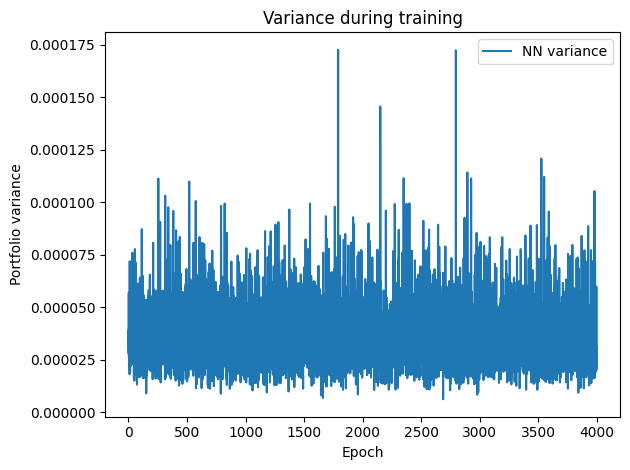

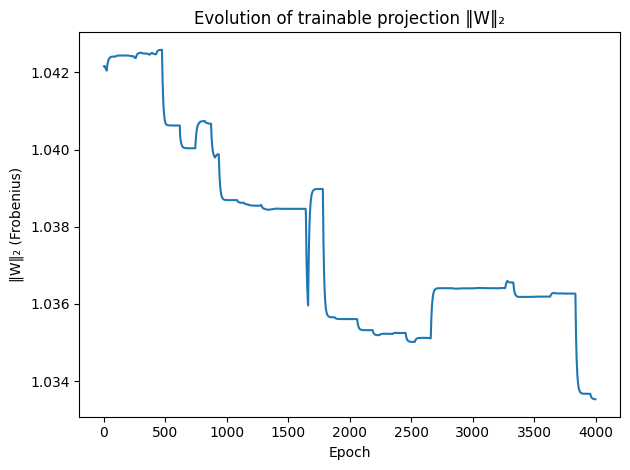

In [ ]:
import matplotlib.pyplot as plt
# ─────────────────── 3.  plots ─────────────────── #
#  (one curve + horizontal line)  –  do not set colours explicitly
plt.figure()
plt.plot(var_hist, label="NN variance")
#plt.axhline(var_base, linestyle="--", label="Baseline variance")
plt.xlabel("Epoch");   plt.ylabel("Portfolio variance")
plt.title("Variance during training")
plt.legend();          plt.tight_layout()
plt.show()

plt.figure()
plt.plot(Wnorm_hist)
plt.xlabel("Epoch");   plt.ylabel("‖W‖₂ (Frobenius)")
plt.title("Evolution of trainable projection ‖W‖₂")
plt.tight_layout()
plt.show()